# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação.

# Base de dados e importações

In [ ]:
!gdown --id 1AXsjBK_TAAWgiWKq-68xuc91btNcLRcW --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1AXsjBK_TAAWgiWKq-68xuc91btNcLRcW
To: /content/dados.zip
35.2MB [00:00, 62.3MB/s]
Archive:  dados.zip
   creating: content/audios_MFCC_especialistas/
  inflating: content/audios_MFCC_especialistas/350e8396-e67e-491a-89dd-666702548d63.jpg  
  inflating: content/audios_MFCC_especialistas/811d96a7-e63f-4a8e-afc8-d8cef7bec7aa.jpg  
  inflating: content/audios_MFCC_especialistas/b408553b-befa-4a28-ab99-a10bb23384fc.jpg  
  inflating: content/audios_MFCC_especialistas/c91f755a-e37e-4106-a90a-bb0672fdfd24.jpg  
  inflating: content/audios_MFCC_especialistas/c35098aa-e1d0-41f2-94b3-38e98f389c9f.jpg  
  inflating: content/audios_MFCC_especialistas/bb84b88b-acd0-4975-8d43-0d0ebbf071f3.jpg  
  inflating: content/audios_MFCC_especialistas/43df4f16-fb75-43bb-a866-5231a9243e21.jpg  
  inflating: content/audios_MFCC_especialistas/e1259ecf-0b60-4106-9852-61c945065ab1.jpg  
  inflating: content/audios_MFCC_especialistas/aa78817e-f5e3-470b-b516-6006c59

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

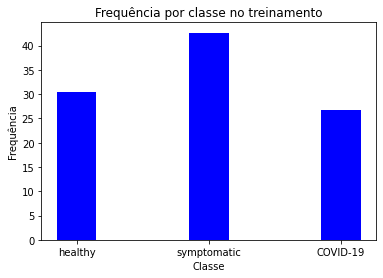

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

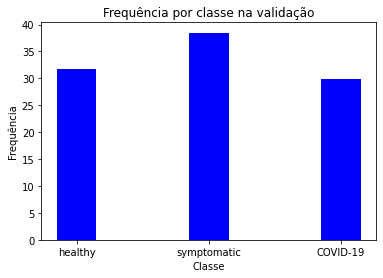

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

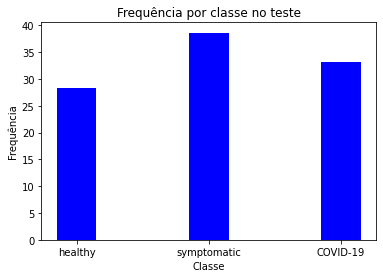

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

In [ ]:
efficientnetb1 = tf.keras.applications.EfficientNetB1(include_top=False, pooling='avg', input_shape=(256, 256, 3))
efficientnetb7 = tf.keras.applications.EfficientNetB7(include_top=False, pooling='avg', input_shape=(256, 256, 3))
densenet169 = tf.keras.applications.DenseNet169(include_top=False, pooling='avg', input_shape=(256, 256, 3))
inceptionv3 = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))
vgg19 = tf.keras.applications.VGG19(include_top=False, pooling='avg', input_shape=(256, 256, 3))

for layer in efficientnetb1.layers:
    layer.treinable = True
    layer._name = 'ef1' + str(layer._name)
for layer in efficientnetb7.layers:
    layer.treinable = True
    layer._name = 'ef7' + str(layer._name)
for layer in densenet169.layers:
    layer.treinable = True
    layer._name = 'd169' + str(layer._name)
for layer in inceptionv3.layers:
    layer.treinable = True
    layer._name = 'iv3' + str(layer._name)
for layer in vgg19.layers:
    layer.treinable = True
    layer._name = 'vgg19' + str(layer._name)


concatenate = tf.keras.layers.concatenate([efficientnetb1.output, efficientnetb7.output, densenet169.output, inceptionv3.output, vgg19.output])
densa = tf.keras.layers.Dense(1000, activation='relu')(concatenate)
output = tf.keras.layers.Dense(3, activation='softmax')(densa)

model = tf.keras.models.Model(inputs = [efficientnetb1.input, efficientnetb7.input, densenet169.input, inceptionv3.input, vgg19.input], outputs=[output])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ef7input_2 (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
ef7rescaling_1 (Rescaling)      (None, 256, 256, 3)  0           ef7input_2[0][0]                 
__________________________________________________________________________________________________
ef7normalization_1 (Normalizati (None, 256, 256, 3)  7           ef7rescaling_1[0][0]             
__________________________________________________________________________________________________
ef7stem_conv_pad (ZeroPadding2D (None, 257, 257, 3)  0           ef7normalization_1[0][0]         
_____________________________

In [ ]:
def get_flow_from_dataframe(dataframe):

  generator_effb1 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
  effb1_images = generator_effb1.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=8, shuffle=True, seed=42)
  
  generator_effb7 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
  effb7_images = generator_effb7.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=8, shuffle=True, seed=42)
  
  generator_d169 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
  d169_images = generator_d169.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=8, shuffle=True, seed=42)
  
  generator_iv3 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
  iv3_images = generator_iv3.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=8, shuffle=True, seed=42)
  
  generator_vgg19 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
  vgg19_images = generator_vgg19.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=8, shuffle=True, seed=42)
  
  while True:
    x_1 = effb1_images.next()
    x_2 = effb7_images.next()
    x_3 = d169_images.next()
    x_4 = iv3_images.next()
    x_5 = vgg19_images.next()

    yield [x_1[0], x_2[0], x_3[0], x_4[0], x_5[0]], x_1[1]

In [ ]:
train_generator = get_flow_from_dataframe(train)
val_generator = get_flow_from_dataframe(val)

In [ ]:
def treina_rede(model, train_generator, val_generator, batch_size=8, callbacks=[], loss='categorical_crossentropy', epochs=500, class_weights=class_weights):
  optimizer = tf.keras.optimizers.Adam(1e-10)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/rede.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs, steps_per_epoch=1111//batch_size, validation_steps=278//batch_size)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  return model

# Modelo

Found 1111 validated image filenames belonging to 3 classes.
Found 1111 validated image filenames belonging to 3 classes.
Found 1111 validated image filenames belonging to 3 classes.
Found 1111 validated image filenames belonging to 3 classes.
Found 1111 validated image filenames belonging to 3 classes.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
138/138 [==============================] - ETA: 0s - loss: 3.1253 - acc: 0.4139Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
138/138 [==============================] - 238s 991ms/step - loss: 3.1253 - acc: 0.4139 - val_loss: 2.2425 - val_acc: 0.3529
Epoch 2/500
138/138 [====================

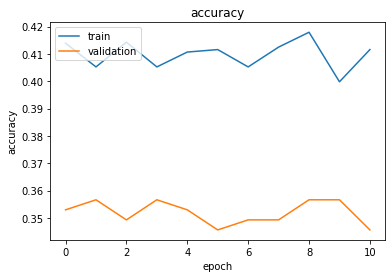

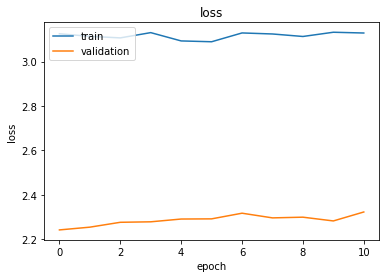

In [ ]:
model = treina_rede(model, train_generator, val_generator, callbacks=['earlystopping', 'reducelr'], batch_size=8)

In [ ]:
def predict_val(dataframe):

  generator_effb1 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
  effb1_images = generator_effb1.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=1, shuffle=False, seed=42)
  
  generator_effb7 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
  effb7_images = generator_effb7.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=1, shuffle=False, seed=42)
  
  generator_d169 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
  d169_images = generator_d169.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=1, shuffle=False, seed=42)
  
  generator_iv3 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
  iv3_images = generator_iv3.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=1, shuffle=False, seed=42)
  
  generator_vgg19 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
  vgg19_images = generator_vgg19.flow_from_dataframe(
      dataframe, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
      target_size=(256, 256), class_mode='categorical', batch_size=1, shuffle=False, seed=42)
  
  while True:
    x_1 = effb1_images.next()
    x_2 = effb7_images.next()
    x_3 = d169_images.next()
    x_4 = iv3_images.next()
    x_5 = vgg19_images.next()

    yield [x_1[0], x_2[0], x_3[0], x_4[0], x_5[0]], x_1[1]

In [ ]:
val_generator = predict_val(val)

In [ ]:
predict_val = model.predict(val_generator, verbose=1, steps=278)
y_true = []

i = 0
for batch, label in val_generator:
  i += label.shape[0]
  for l in np.argmax(label, axis=1):
    y_true.append(l)
  if i == len(val): break

y_true = np.array(y_true)

print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cm) / 3
print('Acuracia balanceada na validacao:', balanced_acc)

Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
278/278 [==============================] - 47s 123ms/step
[[ 0 82  6]
 [ 0 97 10]
 [ 0 76  7]]
Acuracia balanceada na validacao: 0.33029313515745223
